In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import optimize
import matplotlib.pyplot as plt

# funk cover of lizzo? yes plz https://www.youtube.com/watch?v=gNbPoQBm0zM

In [2]:
# Parameters
k = 2
times = np.linspace(0,10,100)

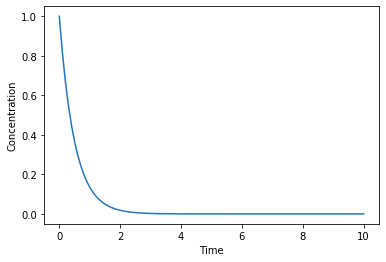

In [3]:
def onecomp(y, t, k):
    dydt = -k * y
    return dydt

def simulate(func, parameters, y0, times):
    return odeint(func, y0, times, (parameters,))

ys = simulate(onecomp, k, 1, times)


# Plot the results
values = ys.reshape((100,))
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, values)
plt.show()

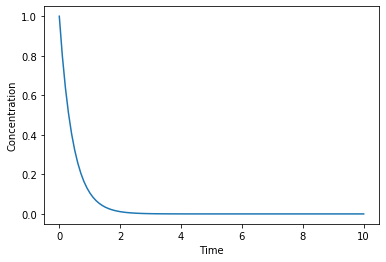

In [4]:
# or you could do it with forward euler
def ForwardEuler(func, k, y0, times):
    y = y0
    y_solution = [y0]
    h = times[2] - times[1]
    
    for n in times[:-1]:
        dy = func(y, n, k)
        y = y + h*dy
        y_solution.append(y)

    return y_solution

# Plot the results
values = ys.reshape((100,))
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.plot(times, ForwardEuler(onecomp, k, 1, times))
plt.show()

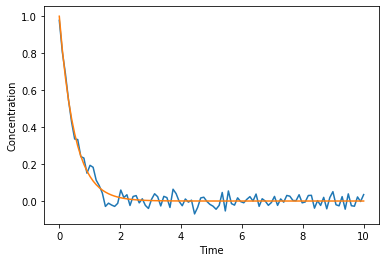

In [5]:
# Make noisy data
noisy_data = values + np.random.normal(0, 0.03, values.shape)
plt.figure()
plt.plot(times, noisy_data)
plt.plot(times, values)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()

In [6]:
# So what do we want to minimise?
def sumofsquares(y_model, y_data):
    sq_error = []
    for t in range(len(y_model)):
        sq_error.append((y_data[t] - y_model[t])**2)
    
    return sum(sq_error) / len(y_model)

In [7]:
# Optimise it with scipy
def scalar_to_minimise(parameters):
    y_model = simulate(onecomp, parameters, 1, times)
    y_data = noisy_data
    return sumofsquares(y_model, y_data)

start_params = 11
result = optimize.minimize_scalar(scalar_to_minimise)
print(result)

     fun: array([0.00093467])
    nfev: 15
     nit: 10
 success: True
       x: array([1.97456698])


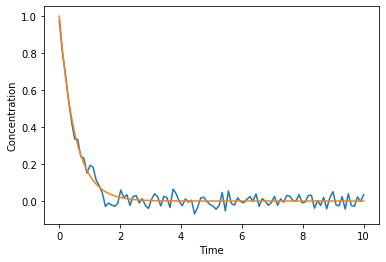

In [8]:
# What does that look like?
recon_model = simulate(onecomp, result.x, 1, times)
plt.figure()
plt.plot(times, noisy_data)
plt.plot(times, recon_model)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.show()